In [1]:

from hamiltonian import Hamiltonian
from rgf import GreensFunction
import numpy as np
import scipy.sparse as sp
import matplotlib.pyplot as plt

In [ ]:
# Sweep Fermi energy and plot transmission for QPC
ham = Hamiltonian("qpc")

ham.W = 10
ham.L = 30
ham.t = 1.0
ham.o = 0.0
ham.Vg = .1  # Moderate barrier

gf = GreensFunction(ham)

energies = np.linspace(-2, 2, 100)
transmission = []
for E in energies:
    transmission.append(gf.compute_transmission(E=E))

plt.plot(energies, transmission)
plt.xlabel('Energy')
plt.ylabel('Transmission')
plt.title('Transmission vs Energy for QPC')
plt.show()

In [ ]:


# # --- Plotting Code ---

# # Extract x and y coordinates from the list of Atom objects
# x_coords = [atom.x for atom in structure]
# y_coords = [atom.y for atom in structure]

# # Create the plot
# plt.figure(figsize=(8, 12))
# plt.scatter(x_coords, y_coords, s=150, edgecolors='black', facecolors='skyblue', zorder=5)

# # Add text labels to identify each atom's index in the list
# for i, (x, y) in enumerate(zip(x_coords, y_coords)):
#     plt.text(x + 0.05, y + 0.05, str(i), fontsize=9, ha='left', va='bottom', zorder=10)

# # Formatting the plot for clarity
# plt.title("Plot of Generated Atom Coordinates", fontsize=16)
# plt.xlabel("X coordinate", fontsize=12)
# plt.ylabel("Y coordinate", fontsize=12)
# plt.axis('equal')  # This is CRUCIAL for correctly visualizing geometric structures
# plt.grid(True, linestyle='--', alpha=0.7)
# plt.show()

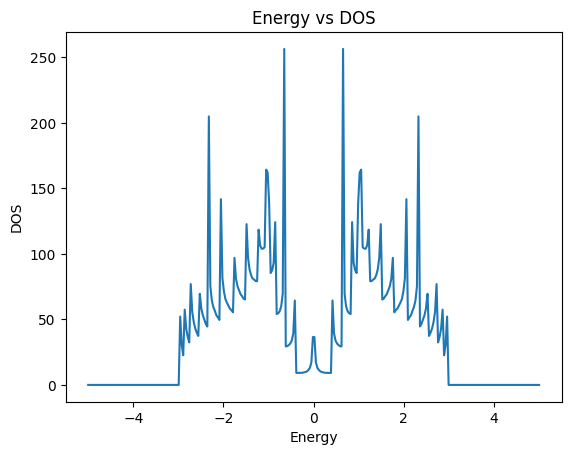

In [11]:
import os
import time

os.environ['OMP_NUM_THREADS'] = '1'
os.environ['MKL_NUM_THREADS'] = '1'
os.environ['OPENBLAS_NUM_THREADS'] = '1'
os.environ['VECLIB_MAXIMUM_THREADS'] = '1'
os.environ['NUMEXPR_NUM_THREADS'] = '1'
from hamiltonian import Hamiltonian
from rgf import GreensFunction
import numpy as np
import scipy.sparse as sp
import matplotlib.pyplot as plt


ham = Hamiltonian("zigzag")
ham.Nx=20
ham.Ny=5

gf = GreensFunction(ham)



energy = np.linspace(-5,5, 300)
dos = [None] * 300

for ide, e in enumerate(energy):
    dos[ide] = np.sum(gf.compute_density_of_states(E=e, self_energy_method="sancho_rubio"))
plt.plot(energy, dos)
plt.ylabel('DOS')
plt.xlabel('Energy')
plt.title('Energy vs DOS')

plt.show()





In [1]:
import os
import time

os.environ['OMP_NUM_THREADS'] = '1'
os.environ['MKL_NUM_THREADS'] = '1'
os.environ['OPENBLAS_NUM_THREADS'] = '1'
os.environ['VECLIB_MAXIMUM_THREADS'] = '1'
os.environ['NUMEXPR_NUM_THREADS'] = '1'
from hamiltonian import Hamiltonian
from rgf import GreensFunction
import numpy as np
import scipy.sparse as sp
import matplotlib.pyplot as plt


ham = Hamiltonian("zigzag", False)


gf = GreensFunction(ham)



energy = np.linspace(-5,5, 300)
dos = gf.calculate_DOS()

In [2]:
print(dos)

[np.float64(7.807965483691064e-06), np.float64(7.97029280188766e-06), np.float64(8.1383519120542e-06), np.float64(8.312440500073281e-06), np.float64(8.49287712432992e-06), np.float64(8.680003083744241e-06), np.float64(8.874184491083746e-06), np.float64(9.075814578489676e-06), np.float64(9.285316266283943e-06), np.float64(9.503145030985289e-06), np.float64(9.729792114200793e-06), np.float64(9.96578812085222e-06), np.float64(1.021170706326557e-05), np.float64(1.0468170917270353e-05), np.float64(1.0735854767960029e-05), np.float64(1.1015492636579546e-05), np.float64(1.130788409665676e-05), np.float64(1.1613901807647626e-05), np.float64(1.1934500118858884e-05), np.float64(1.2270724926315507e-05), np.float64(1.2623725001916816e-05), np.float64(1.299476505942998e-05), np.float64(1.3385240877869064e-05), np.float64(1.3796696872555063e-05), np.float64(1.4230846591512025e-05), np.float64(1.4689596724927752e-05), np.float64(1.5175075354972282e-05), np.float64(1.568966535140098e-05), np.float64(1

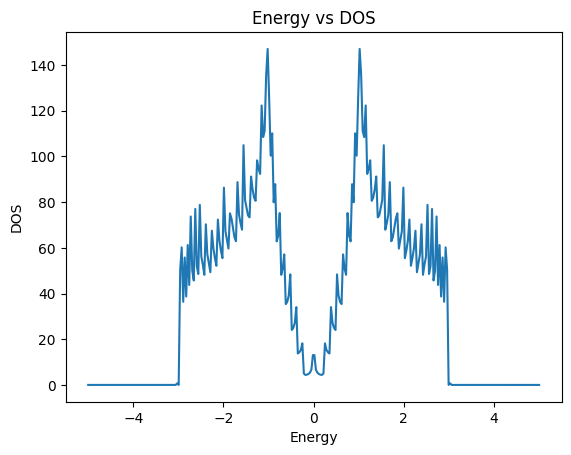

In [3]:

plt.plot(energy, dos)
plt.ylabel('DOS')
plt.xlabel('Energy')
plt.title('Energy vs DOS')

plt.show()

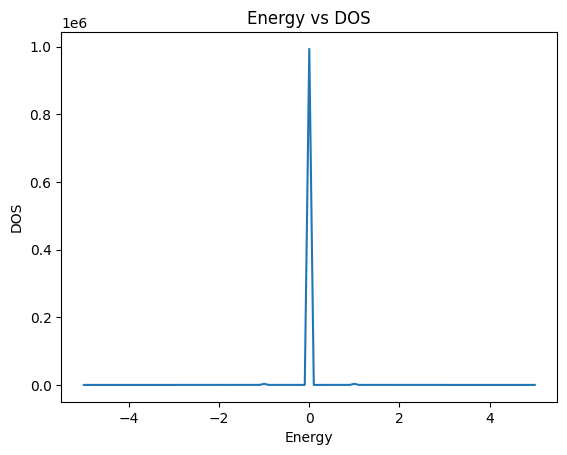

In [10]:

plt.plot(gf.energy_grid, dos)
plt.ylabel('DOS')
plt.xlabel('Energy')
plt.title('Energy vs DOS')

plt.show()